# 1. Цель лабораторной работы

Изучить ансамбли моделей машинного обучения.

# 2. Задание

1.	Выберите набор данных (датасет) для решения задачи классификации или регресии.
2.	В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.	С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4.	Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.
5.	Произведите для каждой модели подбор значений одного гиперпараметра. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.
6.	Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.


# 3. Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков:

In [0]:
from google.colab import files

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

## Предварительная подготовка данных

Датасет - COVID-19 Russia regions cases. COVID-19 virus (coronavirus) has been starting to spread inside of Russia. This is important to investigate and understand the spreading from a very low level. The world-level data is representing Russia virus cases as a single point. But Russia is a very huge and heterogeneous country. For better analyze we have to consider Russia infection cases distributed by region. So this is a dataset of regions distributed COVID-19 virus inside of Russia.

In [50]:
data = pd.read_csv("Measurement_summary.csv", delimiter=',')
data.head(5)

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


Уберем столбец с названиями и реобразуем дату в соответствующий временной формат:

In [51]:
df = data.copy()

df["Measurement date"] = pd.to_datetime(df["Measurement date"]).astype(np.int64)/1000000

df = df.drop(["Address"], axis=1)

'''
df=df.dropna()
'''

'\ndf=df.dropna()\n'

Верхушка данных и типы

In [52]:
df.head()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,1.483229e+12,101,37.572016,127.005007,0.004,0.059,0.002,1.2,73.0,57.0
1,1.483232e+12,101,37.572016,127.005007,0.004,0.058,0.002,1.2,71.0,59.0
2,1.483236e+12,101,37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,59.0
3,1.483240e+12,101,37.572016,127.005007,0.004,0.056,0.002,1.2,70.0,58.0
4,1.483243e+12,101,37.572016,127.005007,0.003,0.051,0.002,1.2,69.0,61.0


In [53]:
df.dtypes

Measurement date    float64
Station code          int64
Latitude            float64
Longitude           float64
SO2                 float64
NO2                 float64
O3                  float64
CO                  float64
PM10                float64
PM2.5               float64
dtype: object

In [54]:
df.isnull().sum()

Measurement date    0
Station code        0
Latitude            0
Longitude           0
SO2                 0
NO2                 0
O3                  0
CO                  0
PM10                0
PM2.5               0
dtype: int64

Проверим основные статистические характеристики набора данных:

In [55]:
df.describe()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,5.180000e+02,518.0,5.180000e+02,5.180000e+02,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,1.484159e+12,101.0,3.757202e+01,1.270050e+02,0.004384,0.038784,0.014178,0.711390,52.490347,36.959459
std,5.388408e+08,0.0,6.401066e-14,1.749625e-12,0.002610,0.019625,0.010952,0.419871,30.897017,27.649651
min,1.483229e+12,101.0,3.757202e+01,1.270050e+02,0.002000,0.007000,0.002000,0.100000,4.000000,1.000000
25%,1.483694e+12,101.0,3.757202e+01,1.270050e+02,0.003000,0.021000,0.003000,0.400000,30.000000,14.000000
50%,1.484159e+12,101.0,3.757202e+01,1.270050e+02,0.004000,0.039000,0.012500,0.600000,45.000000,31.000000
75%,1.484625e+12,101.0,3.757202e+01,1.270050e+02,0.005000,0.054000,0.024000,0.900000,68.750000,53.000000
max,1.485090e+12,101.0,3.757202e+01,1.270050e+02,0.051000,0.086000,0.052000,6.000000,160.000000,149.000000


## Разделение данных

In [0]:
X = df.drop("PM10", axis=1)
y = df["PM10"]

In [57]:
print(X.head(), "\n")
print(y.unique()[1:20])

   Measurement date  Station code   Latitude  ...     O3   CO  PM2.5
0      1.483229e+12           101  37.572016  ...  0.002  1.2   57.0
1      1.483232e+12           101  37.572016  ...  0.002  1.2   59.0
2      1.483236e+12           101  37.572016  ...  0.002  1.2   59.0
3      1.483240e+12           101  37.572016  ...  0.002  1.2   58.0
4      1.483243e+12           101  37.572016  ...  0.002  1.2   61.0

[5 rows x 9 columns] 

[ 71.  70.  69.  66.  72.  74.  76.  83.  93.  94.  87.  91.  92.  89.
  90.  88.  85.  80. 104.]


In [58]:
print(X.shape)
print(y.shape)

(518, 9)
(518,)


Предобработка данных:

In [59]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM2.5
count,5.180000e+02,518.0,518.0,518.0,5.180000e+02,5.180000e+02,5.180000e+02,5.180000e+02,5.180000e+02
mean,2.614811e-17,0.0,0.0,1.0,-3.804336e-16,-3.827912e-16,-7.287178e-18,1.731776e-16,-4.415173e-17
std,1.000967e+00,0.0,0.0,0.0,1.000967e+00,1.000967e+00,1.000967e+00,1.000967e+00,1.000967e+00
min,-1.728710e+00,0.0,0.0,1.0,-9.145276e-01,-1.621080e+00,-1.112951e+00,-1.457545e+00,-1.301797e+00
25%,-8.643552e-01,0.0,0.0,1.0,-5.309444e-01,-9.070331e-01,-1.021558e+00,-7.423493e-01,-8.311734e-01
50%,0.000000e+00,0.0,0.0,1.0,-1.473611e-01,1.102776e-02,-1.533219e-01,-2.655521e-01,-2.157431e-01
75%,8.643552e-01,0.0,0.0,1.0,2.362221e-01,7.760784e-01,8.977006e-01,4.496437e-01,5.806962e-01
max,1.728710e+00,0.0,0.0,1.0,1.788105e+01,2.408187e+00,3.456712e+00,1.260797e+01,4.056067e+00


Разделим выборку на тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=88888888)

In [61]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(388, 9)
(130, 9)
(388,)
(130,)


## Обучение моделей

Метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Случайный лес

Случайный лес с гиперпараметром  n=264 :

In [63]:
ran_264 = RandomForestRegressor(n_estimators=264)
ran_264.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=264, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [64]:
test_model(ran_264)

mean_absolute_error: 3.204662004662005
median_absolute_error: 2.303030303030301
r2_score: 0.9784146930030948


Получаем нормальный результат без настройки.

### Градиентный бустинг

Градиентный бустинг с гиперпараметром  n=264 :

In [65]:
gr_264 = GradientBoostingRegressor(n_estimators=264)
gr_264.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=264,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Метрики построенной модели:

In [66]:
test_model(gr_264)

mean_absolute_error: 3.189330879853889
median_absolute_error: 2.4218792090032437
r2_score: 0.9808810092512654


Результаты аналогичны методу случайного леса

## Подбор гиперпараметра  n

### Случайный лес

Список настраиваемых параметров:

In [75]:
param_range = np.arange(64, 300, 10)
type(param_range)

tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters


[{'n_estimators': array([ 64,  74,  84,  94, 104, 114, 124, 134, 144, 154, 164, 174, 184,
         194, 204, 214, 224, 234, 244, 254, 264, 274, 284, 294])}]

Подбор параметра:

In [76]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=244, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Результаты при разных значения гиперпараметра на тренировочном наборе данных:

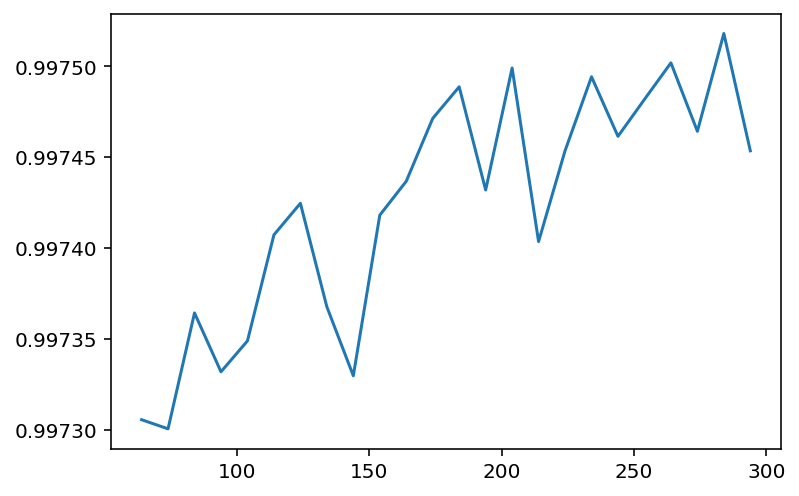

In [77]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

В целом — чем больше обученных моделей, тем лучше.

На тестовом наборе данных:

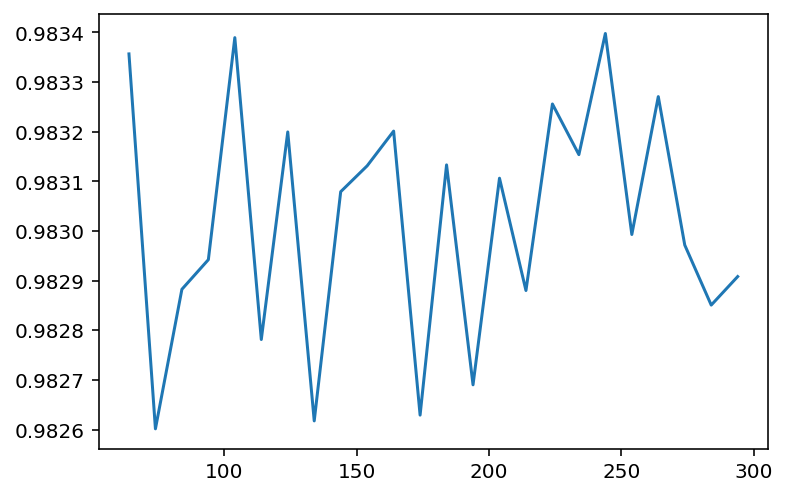

In [78]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

График совсем не ровный, но разница интервала незначительна.

In [82]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 3.1543190416141234
median_absolute_error: 2.264344262295083
r2_score: 0.980016851338987


Результат несколько лучше, чем в исходной модели.

### Градиентный бустинг

Список настраиваемых параметров тот же.

In [95]:
param_range = np.arange(0, 500, 10)
type(param_range)

tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
         130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
         260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
         390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490])}]

Подбор параметра:

In [96]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=470,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Результаты при разных значения гиперпараметра на тренировочном наборе данных:

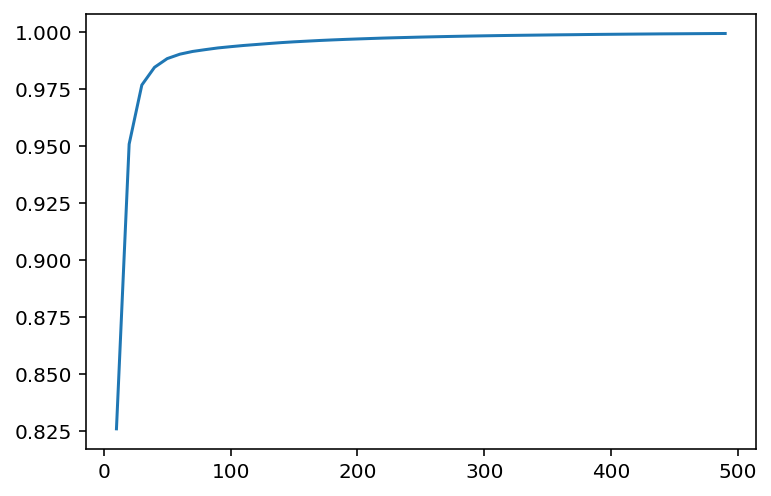

In [97]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Можно заметить, что результаты улучшаются при увеличении числа подмоделей, при большом увеличении скорость улучшения уже незначительна

На тестовом наборе данных:

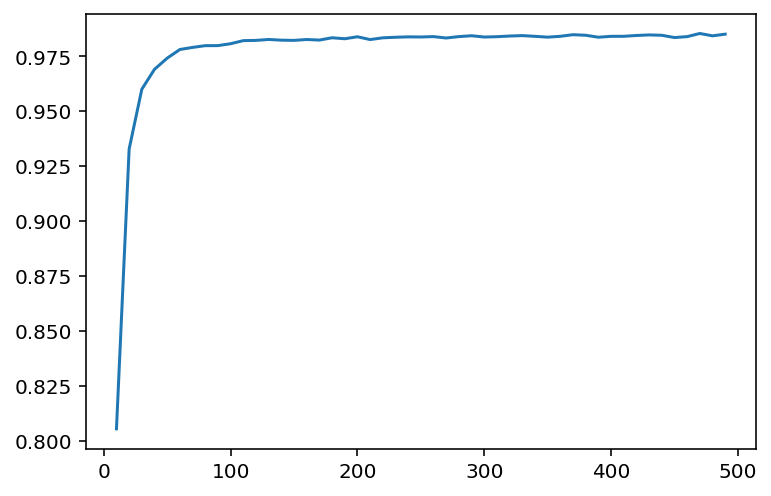

In [98]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Полученные данные подтверждают улучшение результатов при увеличении числа подмоделей.

In [99]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 3.192845416156226
median_absolute_error: 2.49036277202568
r2_score: 0.9801587914372601


Результат идентичен исходной модели